In [1]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.optim.lr_scheduler import StepLR

import seaborn as sns

In [2]:
sns.set()

In [3]:
GPU = True
device = torch.device("cuda:0" if GPU and torch.cuda.is_available() else "cpu")

# Load MNIST

In [4]:
MAX_ROT_DEG = 15
BATCH_SIZE = 128

In [5]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1307,), (0.3081,)),
])
rot_transform = transforms.RandomRotation(MAX_ROT_DEG)

def load_mnist(train, batch_size = BATCH_SIZE):
    dataset = MNIST(
        root = './data/MNIST',
        download = True,
        train = train,
        transform = img_transform,
    )
    return DataLoader(dataset, batch_size = batch_size, shuffle = True)

# Model Definitions

In [6]:
def freeze(model):
    for param in model.parameters():
        param.requires_grad = False

## CNN

In [7]:
CNN_TRAIN_BATCH_SIZE = 64
CNN_TEST_BATCH_SIZE = 1000
CNN_EPOCHS = 1
LR = 1.0
GAMMA = 0.7
LOG_INT = 10

In [8]:
cnn_train_dataloader = load_mnist(True, batch_size = CNN_TRAIN_BATCH_SIZE)
cnn_test_dataloader = load_mnist(False, batch_size = CNN_TEST_BATCH_SIZE)

In [45]:
# Place into numpy arrays for easier manipulation
traindata = list(cnn_train_dataloader)
traindata = [[sample[0].numpy(), sample[1].numpy()] for sample in traindata]
train_X = np.vstack([sample[0] for sample in traindata])
train_y = np.hstack([sample[1] for sample in traindata])

testdata = list(cnn_test_dataloader)
testdata = [[sample[0].numpy(), sample[1].numpy()] for sample in testdata]
test_X = np.vstack([sample[0] for sample in testdata])
test_y = np.hstack([sample[1] for sample in testdata])

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.penultimate_layers(x)
        
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)

    def penultimate_layers(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return F.relu(x)

In [10]:
def vis():
    with torch.no_grad():
        i = 0
        for image_batch, _ in cnn_train_dataloader:
            
            #image_batch = rot_transform(image_batch)
            x = image_batch.to(device)
            #image_batch = image_batch.clamp(0, 1)
            
            print("input:", x.shape)
            npimg = x[0][0].cpu().numpy()
            plt.imshow(npimg)
            plt.show()
    
            x = cnn.conv1(x)
            x = F.relu(x)
            print("conv 1:", x.shape)
            npimg = x[0][0].cpu().numpy()
            plt.imshow(npimg)
            plt.show()
            
            x = cnn.conv2(x)
            x = F.relu(x)
            print("conv 2:", x.shape)
            npimg = x[0][1].cpu().numpy()
            plt.imshow(npimg)
            plt.show()
            
            x = F.max_pool2d(x, 2)
            print("max pool:", x.shape)
            npimg = x[0][1].cpu().numpy()
            plt.imshow(npimg)
            plt.show()
            
            x = cnn.dropout1(x)
            print("dropout:", x.shape)
            npimg = x[0][1].cpu().numpy()
            plt.imshow(npimg)
            plt.show()
            
            x = torch.flatten(x, 1)
            print("flatten:", x.shape)
            npimg = x[0].cpu().numpy()
            plt.imshow(np.expand_dims(npimg, axis = 0))
            plt.show()
            
            x = cnn.fc1(x)
            print("fc1:", x.shape)
            x = F.relu(x)
            print("relu:", x.shape)
            x = cnn.dropout2(x)
            print("dropout:", x.shape)
            x = cnn.fc2(x)
            print("fc2:", x.shape)
            print(x[0])
            print(F.log_softmax(x, dim=1)[0])
    
            break

In [11]:
def train(
    model, optimizer,
    device = device, train_loader = cnn_train_dataloader, epoch = 14
):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #if batch_idx % LOG_INT == 0:
        if False:
            print(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(),
                )
            )

def test(model, device = device, test_loader = cnn_test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            # get the index of the max log-probability
            pred = output.argmax(dim = 1, keepdim = True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Training and Evaluation

In [12]:
cnn = Net().to(device)
optimizer = torch.optim.Adadelta(cnn.parameters(), lr = LR)

scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)
for epoch in range(1, CNN_EPOCHS + 1):
    train(cnn, optimizer)
    test(cnn)
    scheduler.step()

Test set: Average loss: 0.0540, Accuracy: 9824/10000 (98%)


In [13]:
freeze(cnn)

### TODO: figure out saving and loading models on Google Drive

## VAE

In [31]:
#SEED = 100

LAT_DIM = 2
EPOCH_NUM = 5
CAPACITY = 64
LRN_RATE = 1e-3
VAR_BETA = 1

KERN_SIZE = 4
STRIDE = 2
PAD = 1

RECON_CH = 1

In [32]:
CURR_BATCH_SIZE = 64

def reconstruction_error(recon_x, x):
    return F.binary_cross_entropy(
        recon_x.view(-1, CURR_BATCH_SIZE * 128),
        x.view(-1, CURR_BATCH_SIZE * 128),
        reduction = "sum",
    )

def vae_loss(recon_loss, mu, logvar):
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + VAR_BETA * kl_divergence

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.fc_mu = nn.Linear(
            in_features = 128,
            out_features = LAT_DIM,
        )
        self.fc_logvar = nn.Linear(
            in_features = 128,
            out_features = LAT_DIM,
        )
        
    def forward(self, x):
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(
            in_features = LAT_DIM,
            out_features = 128,
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 128)
        return torch.sigmoid(x)

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

### Training and Evaluation



In [34]:
def train_one_model(evaluate = False, train_dataloader = cnn_train_dataloader):
    """ Creates and trains one VAE model.

    Args:
        evaluate: Whether or not to evaluate model during training.

    Returns:
        Tuple containing the trained model, average training reconstruction
        error, average total training error, average testing reconstruction
        error, and average total testing error.
    """

    #torch.cuda.manual_seed(SEED)
    vae = VariationalAutoencoder()
    vae = vae.to(device)
    
    num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
    print('Number of parameters: %d' % num_params)
    
    optimizer = torch.optim.Adam(
        params = vae.parameters(),
        lr = LRN_RATE,
        weight_decay = 1e-5,
    )
    
    # set to training mode
    vae.train()
    
    if evaluate:
        train_recon_loss, train_loss = [], []
        test_recon_loss, test_loss = [], []
    
    print("Training: ", end = "")
    for epoch in range(EPOCH_NUM):
        if evaluate:
            train_loss.append(0)
            train_recon_loss.append(0)
        num_batches = 0
        
        for image_batch, _ in train_dataloader:
            
            #image_batch = rot_transform(image_batch)
            image_batch = image_batch.to(device)
            image_batch = cnn.penultimate_layers(image_batch)
    
            # vae reconstruction
            #print(len(image_batch), end = ", ")
            global CURR_BATCH_SIZE
            CURR_BATCH_SIZE = len(image_batch)
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
            
            # reconstruction error
            recon_loss = reconstruction_error(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # one step of the optmizer (using the gradients from backpropagation)
            optimizer.step()
            
            if evaluate:
                train_loss[-1] += loss.item()
                train_recon_loss[-1] += recon_loss
                
            num_batches += 1
            
        if evaluate:
            train_loss[-1] /= num_batches
            train_recon_loss[-1] /= num_batches
        
            recon_loss_avg, loss_avg = eval_model(vae)
            test_recon_loss.append(recon_loss_avg)
            test_loss.append(loss_avg)
            vae.train()
        
        print("%d, " % (epoch+1), end = "")
        
    print()
    if evaluate: 
        plot_loss(
            [train_loss, train_recon_loss],
            [test_loss, test_recon_loss],
        )
        
    return vae

In [35]:
def eval_model(vae, test_dataloader = cnn_test_dataloader):
    vae.eval()
    
    test_loss_avg, test_recon_loss_avg, num_batches = 0, 0, 0
    sum = 0
    for image_batch, _ in test_dataloader:
        
        with torch.no_grad():
        
            image_batch = image_batch.to(device)
            image_batch = cnn.penultimate_layers(image_batch)
            global CURR_BATCH_SIZE
            CURR_BATCH_SIZE = len(image_batch)
    
            # vae reconstruction
            image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
    
            # reconstruction error
            recon_loss = reconstruction_error(image_batch_recon, image_batch)
            loss = vae_loss(recon_loss, latent_mu, latent_logvar)
    
            test_recon_loss_avg += recon_loss
            test_loss_avg += loss.item()
            num_batches += 1
        
    test_recon_loss_avg /= num_batches
    test_loss_avg /= num_batches

    return test_recon_loss_avg, test_loss_avg
    #print('average reconstruction error: %f' % (test_recon_loss_avg))
    #print('average error: %f' % (test_loss_avg))

In [36]:
def plot_loss(train_losses, test_losses):
    plt.ion()

    plotlabels = ["Total error", "Reconstruction error"]
    
    ncols = 2
    fig, ax = plt.subplots(ncols = ncols, figsize = (9, 2.5))
    
    for i in range(2): 
        ax[i].plot(train_losses[i], c = "blue", label = "training")
        ax[i].plot(test_losses[i], c = "red", label = "test")
            
        ax[i].set_title(plotlabels[i])
        
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.legend()
    plt.show()

Number of parameters: 900
Training: 1, 2, 3, 4, 5, 


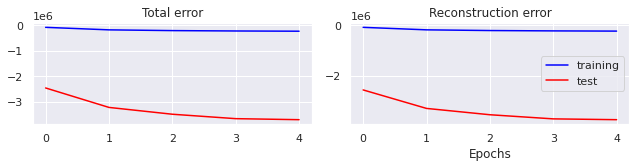

In [37]:
vae1 = train_one_model(evaluate = True)

In [38]:
def train_and_test_models(
    n, gamma_matrix, alpha_matrix, beta_matrix, evaluate = False,
):
    """
    Train n models and compute the MNIST heterogeneities on the models.

    Returns:
        Heterogeneity "matrices" that are lists of np arrrays.
        matrix[i] is the heterogeneity array for vae_i
        matrix[i][j] is the heterogeneity for digit_j for vae_i
    """
    for _ in range(n):
        vae = train_one_model(evaluate = evaluate)
        
        gammas, alphas, betas = calculate_rrh(vae)
        gamma_matrix.append(gammas)
        alpha_matrix.append(alphas)
        beta_matrix.append(betas)
    return gamma_matrix, alpha_matrix, beta_matrix

def plot_rrh_matrices(gamma_matrix, alpha_matrix, beta_matrix):
    gamma_avg = het_avg(gamma_matrix)
    alpha_avg = het_avg(alpha_matrix)
    beta_avg = het_avg(beta_matrix)
    
    gamma_sigma = het_sigma(gamma_matrix)
    alpha_sigma = het_sigma(alpha_matrix)
    beta_sigma = het_sigma(beta_matrix)
    
    plot_rrh(
        gamma_avg, alpha_avg, beta_avg,
        sigmas = [gamma_sigma, alpha_sigma, beta_sigma],
    )

## RRH for Gaussian Mixtures

In [39]:
def mvn_renyi(C, q=1):
    """ Computes the Rényi heterogeneity for a multivariate Gaussian 
    Arguments: 
        C: `ndarray((n,n))`. Covariance matrix
        q: `0<float`. Order of the heterogeneity
    Returns: 
        `float`
    """
    n = C.shape[0]
    SqrtDetC = np.sqrt(np.linalg.det(C))
    if q == 1: 
        out = (2*np.pi*np.e)**(n/2) * SqrtDetC
    elif q == np.inf: 
        out = (2*np.pi)**(n/2) * SqrtDetC
    elif q!=1 and q!=0 and q!=np.inf:
        out = ((2*np.pi)**(n/2))*(q**(n/(2*(q-1))))*SqrtDetC
    return out

In [40]:
def mvn_renyi_alpha(C,  q=1):
    """ Computes the alpha-heterogeneity for a Gaussian mixture where each sample has equal weight

    Arguments: 

        cov: `ndarray((nsamples, n, n))`. Covariance matrices 
        q: `0<float`. Order of the heterogeneity metric

    Returns: 

        `float`. The alpha-heterogeneity
    """
    K, n, _ = C.shape
    p = np.repeat(1/K, K)
    if q == 1:
        out = np.exp((n + np.sum(p*np.log(np.linalg.det(2*np.pi*C))))/2)
    elif q!=np.inf and q!=1 and q!=0:
        wbar = (p**q)/np.sum(p**q)
        out = ((2*np.pi)**(n/2))*np.sum(wbar*np.sqrt(np.linalg.det(C)))/(q**(n/2))**(1/(1-q))
    return out


In [41]:
def scale_to_cov(scales):
    return np.vstack([np.expand_dims(np.diagflat(s), 0) for s in scales])

In [42]:
def pool_covariance(means, covs):
    K = covs.shape[0] 
    p = np.repeat(1/K, K)
    cov_ = np.einsum('ijk,i->jk', covs, p) + np.einsum('ij,ik,i->jk', means, means, p)
    mu_ = np.einsum('ij,i->j', means, p)
    return cov_ - np.einsum('i,j->ij', mu_, mu_)

### Computation and plotting

In [46]:
def calculate_rrh(vae, X = train_X, y = train_y):
    gammas, alphas, betas = [], [], []
    for i in range(10):
        mu, logvar = vae.encoder(
            cnn.penultimate_layers(
                torch.Tensor(X[y == i]).to(device)
            )
        )
        loc = mu.cpu().detach().numpy()
        scale = logvar.exp().cpu().detach().numpy()
        cov = scale_to_cov(scale)
        gamma = mvn_renyi(pool_covariance(loc, cov), q=1)
        alpha = mvn_renyi_alpha(cov,q=1)
        beta = gamma/alpha
        gammas.append(gamma)
        alphas.append(alpha)
        betas.append(beta)
    return np.array(gammas), np.array(alphas), np.array(betas)

In [47]:
def plot_rrh(gammas, alphas, betas, sigmas = None):
    if not (len(gammas) == len(alphas) or len(gammas) == len(betas)):
        sys.exit("Mismatched matrix size")
    n = len(gammas)
    hetvalues = [gammas, alphas, betas]
    plotlabels = [r"Pooled", r"Within-Observation", r"Between-Observation"]
    
    fig, ax = plt.subplots(ncols=3, figsize=(9, 2.5))
    ax[0].set_ylabel("Heterogeneity")
    
    for i in range(3): 
        ax[i].set_title(plotlabels[i])
        ax[i].set_xlabel("Digit")
        ax[i].set_xticks(np.arange(10))
        ax[i].set_xticklabels(np.arange(10))
        ax[i].bar(
            np.arange(10),
            hetvalues[i],
            facecolor = plt.get_cmap("Greys")(0.4), 
            edgecolor = "black",
        )
        if not sigmas == None:
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i],
                fmt = "none",
                ecolor = "r",
                capsize = 3,
                label = "std deviation",
            )
            ax[i].errorbar(
                np.arange(10),
                hetvalues[i],
                yerr = sigmas[i] / np.sqrt(n),
                fmt = "none",
                ecolor = "b",
                capsize = 3,
                label = "std error",
            )
    plt.tight_layout()
    plt.show()
    #plt.savefig("digit-class-heterogeneity.pdf", bbox_inches="tight")

In [48]:
def het_sigma(matrix, avg = None):
    if avg == None:
        avg = het_avg(matrix)
    n = len(matrix)
    mse = (matrix[0] - avg) ** 2
    for i in range(1, n):
        mse += (matrix[i] - avg) ** 2
    return np.sqrt(mse / n)

def het_sum(matrix):
    sum = matrix[0] + matrix[1]
    for i in range(2, len(matrix)):
        sum += matrix[i]
    return sum

def het_avg(matrix):
    return het_sum(matrix) / len(matrix)

# Experiments

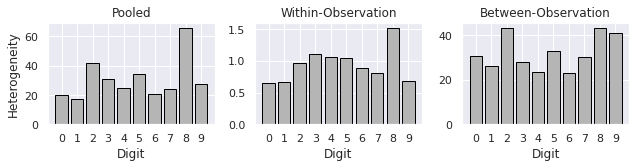

In [49]:
gammas, alphas, betas = calculate_rrh(vae1)
plot_rrh(gammas, alphas, betas)